In [1]:
import pandas as pd
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn
from scipy.spatial.distance import cdist
import cartopy.crs as ccrs
import cartopy.feature as cf
from functions.fun_sdk import *

os.environ['TZ'] = 'UTC'

In [2]:
doi = "2021-06-08"

y_oi = doi.split('-')[0]
m_oi = doi.split('-')[1]
d_oi = doi.split('-')[2]

# Get tobac tracking data
fname = "/Volumes/Elements/data/tobac/Save/"+y_oi+"/"+m_oi+"/"+d_oi+"/Track.nc"
ds = nc.Dataset(fname)

frame = ds.variables['frame'][:]
idx = ds.variables['idx'][:]
hdim_1 = ds.variables['hdim_1'][:]
hdim_2 = ds.variables['hdim_2'][:]
num = ds.variables['num'][:]
threshold_value = ds.variables['threshold_value'][:]
feature = ds.variables['feature'][:]
time = ds.variables['time'][:]
timestr = ds.variables['timestr'][:]
latitude = ds.variables['latitude'][:]
longitude = ds.variables['longitude'][:]
cell = ds.variables['cell'][:]
time_cell = ds.variables['time_cell'][:]

data = pd.DataFrame({'frame':frame, 'idx': idx, 'hdim_1':hdim_1, 'hdim_2':hdim_2,
'num':num, 'threshold_value': threshold_value, 'feature': feature, 'time':time,'timestr':timestr, 'latitude': latitude, 'longitude':longitude, 'cell':cell, 'time_cell':time_cell})

# delete all rows where data.cell is NaN
# these rows are not connected to an individual object
data = data.dropna(subset = ['cell'])

In [3]:
# get regular time interval (should be 5 minutes for SEVIRI rapid scan)
ts = np.arange(1,len(data.time.unique()),1)
for i in np.arange(1,len(data.time.unique()),1):
    ts[i-1] = data.time.unique()[i]-data.time.unique()[i-1]
ts = 300 * round(ts.mean()/300)/60

print('time interval: '+str(ts)+' min')

time interval: 5.0 min


In [4]:
# Check if output path exists
savedir=y_oi+'/'+m_oi+'/'+d_oi
if not os.path.exists('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir):
    os.makedirs('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir)

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


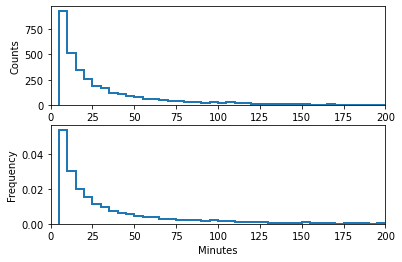

In [5]:
##################
# CELL LIFETIMES #
##################

# calculate life time (minutes)
cellID = data.cell.unique().astype(int)
cell_occ = pd.DataFrame()
for i in np.arange(0,len(cellID),1):
    temp_row = pd.DataFrame([{'cellID':cellID[i], 'occ':ts*len(data[data.cell == cellID[i]])-ts}])
    cell_occ = pd.concat([cell_occ,temp_row],axis=0)
cell_occ = cell_occ.reset_index(drop=True)

cell_occ.to_csv('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/cell_lifetimes.csv', index=False)

# Plot the cell lifetimes
# Histogram
fig, (ax1, ax2) = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
ax1.hist(cell_occ.occ,histtype='step', linewidth = 2, bins = int((cell_occ.occ.max()-cell_occ.occ.min())/ts))
ax1.set_xlim(0,200)
ax1.set_ylabel('Counts')

# Probability density function (PDF)
seaborn.distplot(cell_occ.occ,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((cell_occ.occ.max()-cell_occ.occ.min())/ts))
ax2.set_xlim(0,200)
ax2.set_xlabel('Minutes')
ax2.set_ylabel('Frequency')

plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/cell_lifetimes.png',dpi=256,facecolor='white',transparent=False)

# Histogram
#plt.figure(figsize=(8,4))
#plt.hist(cell_occ.occ,histtype='step', linewidth = 2, bins = int((cell_occ.occ.max()-cell_occ.occ.min())/ts))
#plt.hlines(0,xmin=0,xmax=cell_occ.occ.min())
#plt.xlim(0,cell_occ.occ.max())
#plt.xlabel('Minutes')
#plt.ylabel('Counts')
#plt.show()

# Probability density function (PDF)
#plt.figure(figsize=(8,4))
#seaborn.distplot(cell_occ.occ,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((cell_occ.occ.max()-cell_occ.occ.min())/ts))
#plt.hlines(0,xmin=0,xmax=cell_occ.occ.min())
#plt.xlim(0,cell_occ.occ.max())
#plt.xlabel('Minutes')
#plt.ylabel('Frequency')
#plt.show()

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


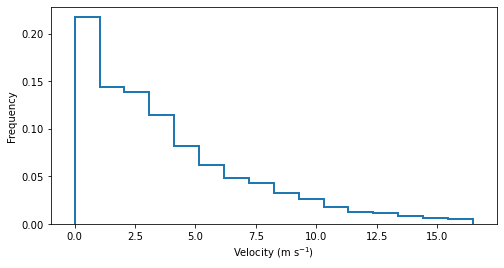

In [6]:
#################
# CELL VELOCITY #
#################

cellID = data.cell.unique().astype(int)
cvelo = pd.DataFrame()

for k in np.arange(0,len(cellID),1):
    cdata = data[data.cell == cellID[k]]
    cdata = cdata.reset_index(drop=True)

    velocity = pd.DataFrame({'velocity':np.arange(1,len(cdata),1).astype(float)})
    for i in np.arange(1,len(cdata),1):
        ydist = cdata.hdim_1[i]-cdata.hdim_1[i-1] # distance along latitude in km
        xdist = cdata.hdim_2[i]-cdata.hdim_2[i-1] # distance along longitude in km

        dist = np.sqrt(xdist**2+ydist**2)*550 # distance in m
        velocity.velocity[i-1] = dist/(ts*60)
    
    cvelocity = pd.concat([pd.DataFrame({'cell':np.repeat(cellID[k],len(cdata)-1), 'timestr':list(cdata.timestr.loc[1:len(cdata)])}),velocity],axis=1)
    cvelo = pd.concat([cvelo,cvelocity], axis = 0)
    cvelo = cvelo.reset_index(drop=True)

cvelo.to_csv('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/cell_velocity.csv', index=False)

plt.figure(figsize=(8,4))
seaborn.distplot(cvelo.velocity,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((cvelo.velocity.max()-cvelo.velocity.min())))
plt.xlim(-1,cvelo.velocity.max()+1)
plt.xlabel('Velocity (m s$^{-1}$)')
plt.ylabel('Frequency')
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/cell_velocity.png',dpi=256,facecolor='white',transparent=False)

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


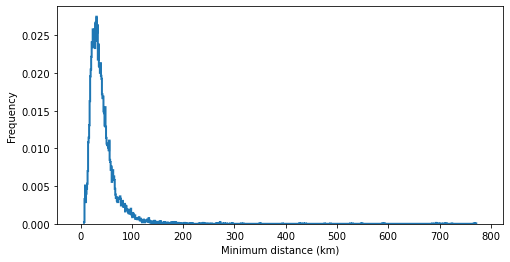

In [7]:
####################
# MINIMUM DISTANCE #
####################

tsteps = data.timestr.unique()
mindist = pd.DataFrame()

for i in np.arange(0,len(tsteps),1):
    tdata = data[data.timestr == tsteps[i]]
    tdata = tdata.reset_index(drop=True)
    dimtdata = np.array(tdata[['hdim_1','hdim_2']])
    cellID = tdata.cell.unique().astype(int)

    for c in np.arange(0,len(cellID),1):
        tcdata = tdata[tdata.cell == cellID[c]]
        tcdata = tcdata.reset_index(drop=True)
        dimtcdata = np.array(tcdata[['hdim_1','hdim_2']])

        tcdist = cdist(dimtdata, dimtcdata, 'euclidean')
        tcdist[tcdist > 0].min()

        mindist = pd.concat([mindist, pd.DataFrame([{'cell':cellID[c], 'timestr':tsteps[i], 'mindist':tcdist[tcdist > 0].min()}])], axis = 0)

mindist.to_csv('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/min_distance.csv', index=False)

plt.figure(figsize=(8,4))
seaborn.distplot(mindist.mindist,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((mindist.mindist.max()-mindist.mindist.min())))
plt.xlabel('Minimum distance (km)')
plt.ylabel('Frequency')
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/min_distance.png',dpi=256,facecolor='white',transparent=False)

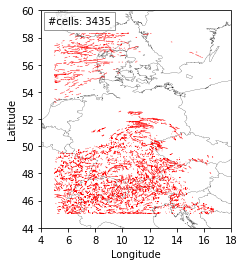

In [8]:
##############
# ALL TRACKS #
##############

cellID = data.cell.unique().astype(int)

ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([4, 18, 44, 60])
ax.add_feature(cf.COASTLINE, linewidth = 0.2)
ax.add_feature(cf.BORDERS, linewidth = 0.2)
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
t = ax.text(x = 4.5, y = 59, s = '#cells: '+str(len(cellID)))
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='grey'))

for i in np.arange(0,len(cellID),1):
    test = data[data.cell == cellID[i]]
    plt.plot(test.longitude, test.latitude, c = 'red', linewidth = 0.5)

plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/tracks.png',dpi=256,facecolor='white',transparent=False)

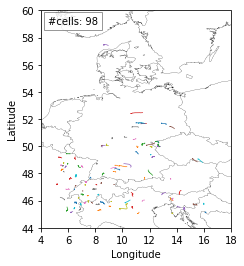

In [9]:
#################
# FILTER TRACKS #
#################

Filter_1 = True # 60 min lifetime
Filter_2 = False # minimum distance > 30 km
Filter_3 = True # first detection at 260 K threshold
Filter_4 = True # minimum CTT of 240 K

cells = cellID

# FILTER 1
if Filter_1 == True:
    # All cellIDs with minimum 60 minutes lifetime
    cells = cell_occ.cellID[cell_occ.occ >= 60]
    cells = cells.reset_index(drop=True)

# FILTER 2
if Filter_2 == True:
    # Extract stations from mindist
    sh_mindist = mindist[mindist.cell.isin(cells)]
    # All cellIDS with a minimum distance of 30 km (isolated cells)
    for i in np.arange(0,len(cells),1):
        if (len(sh_mindist.mindist[(sh_mindist.cell == cells[i]) & (sh_mindist.mindist > 30)])/len(sh_mindist.mindist[sh_mindist.cell == cells[i]])) < 1:
            sh_mindist = sh_mindist[sh_mindist.cell != cells[i]]
    cells = sh_mindist.cell.unique()

# FILTER 3
if Filter_3 == True:
    # Extract all cells with first detection at 260 K
    cellsdata = pd.DataFrame()
    for i in np.arange(0,len(cells),1):
        cdata = data[data.cell == cells[i]]
        cdata = cdata.reset_index(drop=True)

        if cdata.threshold_value[0] == 260:
            cellsdata = pd.concat([cellsdata,cdata],axis=0)
    cells = cellsdata.cell.unique()

# FILTER 4
if Filter_4 == True:
    # Extract all cells with a minimum threshold value of 240 K
    cellsdata = pd.DataFrame()
    for i in np.arange(0,len(cells),1):
        cdata = data[data.cell == cells[i]]
        cdata = cdata.reset_index(drop=True)

        if cdata.threshold_value.min() <= 240:
            cellsdata = pd.concat([cellsdata,cdata],axis=0)
    cells = cellsdata.cell.unique()

cellspd = pd.DataFrame({'cellID':cells})
cellspd.to_csv('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/cells_filtered.csv', index=False)

ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent([4, 18, 44, 60])
ax.add_feature(cf.COASTLINE, linewidth = 0.2)
ax.add_feature(cf.BORDERS, linewidth = 0.2)
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
t = ax.text(x = 4.5, y = 59, s = '#cells: '+str(len(cells)))
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='grey'))

for i in np.arange(0,len(cells),1):
    test = data[data.cell == cells[i]]
    plt.plot(test.longitude, test.latitude, linewidth = 0.7)

plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/tracks_filtered.png',dpi=256,facecolor='white',transparent=False)

In [20]:
data[data.cell.isin(list(cellspd.cellID))]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,cell,time_cell
993,9,16,400.400896,237.596392,39,260,994,2688,2021-06-04 01:48:48,47.698183,7.258564,372.0,0.0
1107,10,17,401.260907,239.961687,110,260,1108,3072,2021-06-04 01:55:12,47.703726,7.281147,372.0,384.0
1242,11,17,403.277185,241.027343,161,260,1243,3328,2021-06-04 01:59:28,47.716721,7.291321,372.0,640.0
1437,12,87,407.943526,241.705298,24,250,1438,3584,2021-06-04 02:03:44,47.746779,7.297794,372.0,896.0
1563,13,88,408.112424,243.907712,39,250,1564,3968,2021-06-04 02:10:08,47.747867,7.318821,372.0,1280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29424,191,131,344.191726,475.837522,53,240,29425,57344,2021-06-04 16:59:44,47.334607,9.533152,7181.0,3840.0
29436,191,152,1034.468557,839.744137,131,240,29437,57344,2021-06-04 16:59:44,51.625122,13.007520,7057.0,4864.0
29441,191,158,1267.904786,504.500325,110,240,29442,57344,2021-06-04 16:59:44,52.991158,9.806807,7149.0,4224.0
29453,191,175,609.964532,239.771425,1258,230,29454,57344,2021-06-04 16:59:44,49.031405,7.279330,5605.0,14080.0


In [ ]:
cellsmeteo = pd.DataFrame()
for k in np.arange(0,len(cells),1):
    cdata = data[data.cell == cells[k]]
    cdata = cdata.reset_index(drop=True)

    meteo = pd.DataFrame()
    for i in np.arange(0,len(cdata),1):
        start = cdata.timestr[i].split()[0]
        end = cdata.timestr[i].split()[0]

        time = pd.Timestamp(cdata.timestr[i]).round('1 H')

        cois = [[cdata.longitude[i],cdata.latitude[i]]]

        nwpdata = get_surface_model_output(cois, start, end, nwp='ERA5T', apikey='nRMiXJ34HBIwOjlq')

        nwpdata = nwpdata[nwpdata.TIMESTAMP == time]
        nwpdata = nwpdata.iloc[:,3:8]

        meteo = pd.concat([meteo, nwpdata],axis = 0)
        meteo = meteo.reset_index(drop = True)
    meteo = pd.concat([cdata[['timestr','cell']],meteo], axis = 1)
    cellsmeteo = pd.concat([cellsmeteo,meteo],axis=0)

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


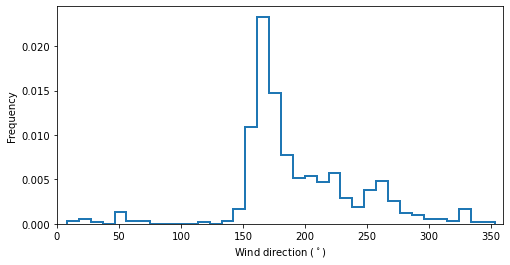

In [ ]:
# WIND DIRECTION
plt.figure(figsize=(8,4))
seaborn.distplot(cellsmeteo.winddir,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = 36)
plt.xlabel('Wind direction ($^\circ$)')
plt.ylabel('Frequency')
plt.xlim(0,360)
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/wind_direction.png',dpi=256,facecolor='white',transparent=False)

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


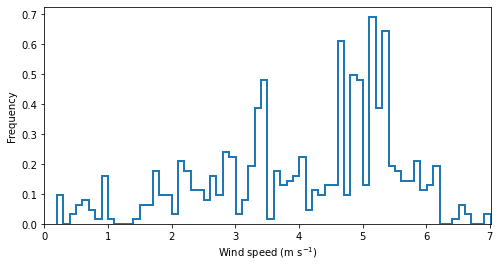

In [ ]:
# WIND SPEED
plt.figure(figsize=(8,4))
seaborn.distplot(cellsmeteo.windspeed/3.6,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int(((cellsmeteo.windspeed/3.6).max()-(cellsmeteo.windspeed/3.6).min())*10))
plt.xlabel('Wind speed (m s$^{-1}$)')
plt.ylabel('Frequency')
plt.xlim(0,(cellsmeteo.windspeed/3.6).max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/wind_speed.png',dpi=256,facecolor='white',transparent=False)

/Users/nicobader/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


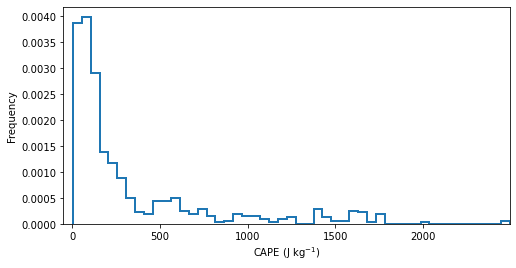

In [ ]:
# CAPE
plt.figure(figsize=(8,4))
seaborn.distplot(cellsmeteo.CAPE,kde = True, hist = True, hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1}, kde_kws={'linewidth':0}, bins = int((cellsmeteo.CAPE.max()-cellsmeteo.CAPE.min())/50))
plt.xlabel('CAPE (J kg$^{-1}$)')
plt.ylabel('Frequency')
plt.xlim(-50,cellsmeteo.CAPE.max())
plt.savefig('/Users/nicobader/Documents/Uni_Leipzig/master_thesis/analysis/tobac_tracking_statistics/'+savedir+'/cape.png',dpi=256,facecolor='white',transparent=False)